In [1]:
import os
import sys
import numpy as np
import swyft
import pickle
import matplotlib.pyplot as plt
import torch
import importlib
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import LearningRateMonitor
torch.set_float32_matmul_precision('medium')
device_notebook = "cuda" if torch.cuda.is_available() else "cpu"
import wandb
import copy
from torch.multiprocessing import Pool
torch.multiprocessing.set_start_method('spawn',force=True)
torch.set_num_threads(28)
import itertools
import subprocess
from tqdm.auto import tqdm
sys.path.append('/home/gertwk/ALPs_with_SWYFT/analysis_scripts/ALP_sim')
from explim_functions import generate_expected_limits
import sympy as sy
from scipy.stats import norm, lognorm
from swyft.plot.mass import _get_jefferys_interval as interval
import random
import matplotlib.gridspec as gridspec
from matplotlib.colors import to_rgb
from matplotlib.ticker import MaxNLocator

In [2]:
main_dir = "ALPs_with_SWYFT"
thesis_figs = os.getcwd().split(main_dir)[0]+"/"+main_dir+"/thesis_figures/"

In [3]:
names = ['flare0_informed',]
colors_priors = ['r','#FFA500','y','g','b', ]

priors = {}
for ip, name in enumerate(names):

    priors[name] = {'name': name}

    priors[name]['results_path'] = '/home/gertwk/ALPs_with_SWYFT/cluster_runs/analysis_results/'+name

    priors[name]['store_path'] = priors[name]['results_path']+"/sim_output/store"

    priors[name]['config_vars'] = priors[name]['results_path'] +'/config_variables.pickle'

    priors[name]['config_phys'] = priors[name]['results_path'] +'/physics_variables.pickle'
    
    priors[name]['truncation_record'] = priors[name]['results_path'] +'/truncation_record.pickle'

    removed_ALP_sim=0
    try:
        sys.path.remove('/home/gertwk/ALPs_with_SWYFT/analysis_scripts/ALP_sim')
        removed_ALP_sim=1
    except ValueError:
        pass
    try:
        del sys.modules['ALP_quick_sim']
    except KeyError:
        pass
    sys.path.append(priors[name]['results_path'])
    import param_function
    import ALP_quick_sim
    with open(priors[name]['config_vars'], 'rb') as file: config_objects = pickle.load(file)
    for key in config_objects.keys(): priors[name][key] = config_objects[key]
    with open(priors[name]['config_phys'], 'rb') as file: config_objects = pickle.load(file)
    for key in config_objects.keys(): priors[name][key] = config_objects[key]
    with open(priors[name]['truncation_record'], 'rb') as file: config_objects = pickle.load(file)
    for key in config_objects.keys(): priors[name][key] = config_objects[key]
    sys.path.remove(priors[name]['results_path'])
    sys.path.append(priors[name]['results_path']+'/train_output/net')
    import network
    sys.path.remove(priors[name]['results_path']+'/train_output/net')
    
    count = 0
    for combo in itertools.product(*priors[name]['hyperparams'].values()):
        if count == priors[name]['which_grid_point']:
            hyperparams_point = {}
            for i, key in enumerate(priors[name]['hyperparams'].keys()):
                hyperparams_point[key]=combo[i]
        count +=1

    priors[name]['net_path'] = {}
    priors[name]['net'] = {}
    for rnd in range(priors[name]['which_truncation']+1):
        round = 'round_'+str(rnd)
        priors[name]['net_path'][round] = (priors[name]['results_path'] + '/train_output/net/trained_network_'
                                                         +round+'_gridpoint_'+str(priors[name]['which_grid_point'])+'.pt')
        priors[name]['net'][round] = network.NetworkCorner(
            nbins=priors[name]['A'].nbins,
            marginals=priors[name]['POI_indices'],
            param_names=priors[name]['A'].param_names,
            **hyperparams_point,
        )
        priors[name]['net'][round].load_state_dict(torch.load(priors[name]['net_path'][round]))

    with open(priors[name]['results_path']+'/explim_predictions.pickle', 'rb') as file:
        priors[name]['predictions'] = pickle.load(file)

    if priors[name]['which_truncation'] > 0:
        store = swyft.ZarrStore(priors[name]['store_path'] + "/" + priors[name]['store_name']+"_round_"+str(priors[name]['which_truncation'])+"_gridpoint_"+str(priors[name]['which_grid_point']))
        store_explim = swyft.ZarrStore(priors[name]['store_path'] + "/" + priors[name]['store_name']+"_explim_round_"+str(priors[name]['which_truncation'])+"_gridpoint_"+str(priors[name]['which_grid_point']))
        store_prior = swyft.ZarrStore(priors[name]['store_path'] + "/" + priors[name]['store_name']+"_prior_round_"+str(priors[name]['which_truncation'])+"_gridpoint_"+str(priors[name]['which_grid_point']))
    else:
        store = swyft.ZarrStore(priors[name]['store_path'] + "/" + priors[name]['store_name'])
        store_explim = swyft.ZarrStore(priors[name]['store_path'] + "/" + priors[name]['store_name']+"_explim")
        store_prior = swyft.ZarrStore(priors[name]['store_path'] + "/" + priors[name]['store_name']+"_prior")
    priors[name]['samples'] = store.get_sample_store()
    priors[name]['samples_explim'] = store_explim.get_sample_store()
    priors[name]['samples_prior'] = store_prior.get_sample_store()
 
    del sys.modules['param_function']
    del sys.modules['ALP_quick_sim']
    del sys.modules['network']
    if removed_ALP_sim: sys.path.append('/home/gertwk/ALPs_with_SWYFT/analysis_scripts/ALP_sim')


/home/gertwk/.conda/envs/swyft4-dev-notebook/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [4]:
trainer = swyft.SwyftTrainer(accelerator = 'cuda', precision = 64,logger=False,)

/home/gertwk/.conda/envs/swyft4-dev-notebook/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/gertwk/.conda/envs/swyft4-dev-notebook/lib/pyt ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [5]:
sys.path.append('/home/gertwk/ALPs_with_SWYFT/analysis_scripts/ALP_sim')

In [6]:
def convert_pair_to_index(pair,n_indices):
    pair = sorted(pair)
    return int((pair[0]+1)*(n_indices-1+n_indices-pair[0]-1)/2 - n_indices + pair[1])

In [7]:
def weight(exp,n_bins):
    x = np.linspace(-1,1,n_bins)
    return 0.5+0.5*np.cos(np.pi*np.sign(x)*np.abs(x)**exp)

In [8]:
stdnorm = norm()

In [9]:
def p_to_z(x):
    return stdnorm.ppf(0.5+x/2)

def z_to_p(x):
    return stdnorm.cdf(x)-stdnorm.cdf(-x)

In [10]:
try:
    del sys.modules['DRP_test']
except KeyError:
    pass
try:
    del sys.modules['reference_functions']
except KeyError:
    pass
from DRP_test import get_drp_coverage, get_drp_coverage_torch, draw_DRP_samples_fast
from reference_functions import References
R = References()
references2D = R.references2D

In [11]:
n_samps = 1000
n_prior_samps=10_000

In [12]:
%%time
name = names[0]
samples = priors[name]['samples'][-3_000:]
prior_samples = priors[name]['samples_prior'][:30_000]
which_truncation = priors[name]['which_truncation']
which_grid_point = priors[name]['which_grid_point']
POIs = priors[name]['POI_indices']
A = priors[name]['A']
bounds = np.array(priors[name]['bounds_rounds'][which_grid_point][which_truncation])

draws1d = {}
draws2d = {}
weights1d = {}
weights2d = {}
for rnd in range(which_truncation+1):
    round = 'round_'+str(rnd)
    draws1d[round],draws2d[round],weights1d[round],weights2d[round] = draw_DRP_samples_fast(
        priors[name]['net'][round],
        trainer,
        samples,
        prior_samples,
        batch_size = 1024*4
    )

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

CPU times: user 2h 14min 37s, sys: 17min 21s, total: 2h 31min 59s
Wall time: 2h 12min 45s


In [13]:
# name = names[0]
# samples = priors[name]['samples'][-5_000:]
# prior_samples = priors[name]['samples_prior'][:50_000]
# which_truncation = priors[name]['which_truncation']
# which_grid_point = priors[name]['which_grid_point']
# POIs = priors[name]['POI_indices']
# A = priors[name]['A']
# bounds = np.array(priors[name]['bounds_rounds'][which_grid_point][which_truncation])

# # draws1d = {}
# # draws2d = {}
# # weights1d = {}
# # weights2d = {}
# for rnd in range(0,2):
#     round = 'round_'+str(rnd)
#     draws1d[round],draws2d[round],weights1d[round],weights2d[round] = draw_DRP_samples_fast(
#         priors[name]['net'][round],
#         trainer,
#         samples,
#         prior_samples,
#         batch_size = 1024*4
#     )

In [14]:
%%time
coverage_samples = {}
for rnd in range(which_truncation+1):
    round = 'round_'+str(rnd)
    coverage_samples[round] = trainer.test_coverage(priors[name]['net'][round], samples, prior_samples)

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

CPU times: user 3h 35min 8s, sys: 2min 33s, total: 3h 37min 41s
Wall time: 2h 10min 20s


In [15]:
round_colors = ['r','y','g','b']

In [16]:
def blend(color1, color2, amount=0.5):
    return tuple(np.array(color1)*amount + np.array(color2)*(1-amount))

In [17]:
which_truncation = 3

In [18]:
%%time
n_refs = 100
references_1d = [
    references2D(samples)[0][:,[0]] for _ in range(n_refs)
]

references_2d = [
    references2D(samples)[0] for _ in range(n_refs)
]

Fitting samples... done.
CPU times: user 1.03 s, sys: 4.03 ms, total: 1.04 s
Wall time: 1.04 s


In [19]:
%%time
ecp_pp = { 'round_'+str(rnd) : [[{} for ref_list in references_1d],[{} for ref_list in references_2d]] for rnd in range(which_truncation+1) }
alpha_pp = { 'round_'+str(rnd) : [[{} for ref_list in references_1d],[{} for ref_list in references_2d]] for rnd in range(which_truncation+1) }
ecp_zz = { 'round_'+str(rnd) : [[{} for ref_list in references_1d],[{} for ref_list in references_2d]] for rnd in range(which_truncation+1) }
alpha_zz = { 'round_'+str(rnd) : [[{} for ref_list in references_1d],[{} for ref_list in references_2d]] for rnd in range(which_truncation+1) }
f_pp = { 'round_'+str(rnd) : [[{} for ref_list in references_1d],[{} for ref_list in references_2d]] for rnd in range(which_truncation+1) }
f_zz = { 'round_'+str(rnd) : [[{} for ref_list in references_1d],[{} for ref_list in references_2d]] for rnd in range(which_truncation+1) }

validation_sums = { 'round_'+str(rnd) : [{},{}] for rnd in range(which_truncation+1) }

for rnd in range(which_truncation+1):
    round = 'round_'+str(rnd)
    
    for i, key in enumerate(draws1d[round].keys()):

        draws = draws1d[round][key]
        samps = samples['params'][:,[POIs[i]]]
        weights = weights1d[round][key]
        
        for ref_i in range(len(references_1d)):

            random_indices = random.sample(list(np.arange(len(samples))), n_samps)
            random_prior_indices = random.sample(list(np.arange(len(prior_samples))), n_prior_samps)
    
            ecp_pp[round][0][ref_i][key], alpha_pp[round][0][ref_i][key], ecp_zz[round][0][ref_i][key], alpha_zz[round][0][ref_i][key], f_pp[round][0][ref_i][key], f_zz[round][0][ref_i][key], f_score, _ = get_drp_coverage_torch(
                draws[random_prior_indices][:,random_indices,:],
                samps[random_indices],
                weights = weights[random_prior_indices][:,random_indices],
                theta_names=A.param_names[POIs[i]],
                bounds = np.array(bounds)[[POIs[i]]],
                references = references_1d[ref_i][random_indices],
                device='cuda',
                intermediate_figures=False,
            )

            if ref_i == 0: validation_sums[round][0][key] = 0
            # uncertainty = (interval((alpha_pp[round][0][ref_i][key]*n_samps).astype(int),n_samps)[:,1]-interval((alpha_pp[round][0][ref_i][key]*n_samps).astype(int),n_samps)[:,0])/2
            # validation_sums[round][0][key] += np.sum(((ecp_pp[round][0][ref_i][key]-alpha_pp[round][0][ref_i][key])/uncertainty)**2)/n_samps
            validation_sums[round][0][key] += f_score/n_refs
            
rows = len(POIs)

for rnd in range(which_truncation+1):
    round = 'round_'+str(rnd)
    row = 0
    column = 0
    for i, key in enumerate(draws2d[round].keys()):
        row+=1
        if row >= rows:
            column+=1
            row = 1+column  
    
        draws = draws2d[round][key]
        samps = samples['params'][:,[column,row]]
        weights = weights2d[round][key]
    
        for ref_i in range(len(references_2d)): 
    
            random_indices = random.sample(list(np.arange(len(samples))), n_samps)
            random_prior_indices = random.sample(list(np.arange(len(prior_samples))), n_prior_samps)
        
            ecp_pp[round][1][ref_i][key], alpha_pp[round][1][ref_i][key], ecp_zz[round][1][ref_i][key], alpha_zz[round][1][ref_i][key], f_pp[round][1][ref_i][key],f_zz[round][0][ref_i][key], f_score, _ = get_drp_coverage_torch(
                draws[random_prior_indices][:,random_indices,:],
                samps[random_indices],
                weights = weights[random_prior_indices][:,random_indices],
                theta_names=np.array(A.param_names)[[column,row]],
                bounds = np.array(bounds)[[column,row]],
                references = references_2d[ref_i][random_indices],
                device='cuda',
                intermediate_figures=False,
            )

            if ref_i == 0: validation_sums[round][1][key] = 0
            # uncertainty = (interval((alpha_pp[round][1][ref_i][key]*n_samps).astype(int),n_samps)[:,1]-interval((alpha_pp[round][1][ref_i][key]*n_samps).astype(int),n_samps)[:,0])/2
            # validation_sums[round][1][key] += np.sum(((ecp_pp[round][1][ref_i][key]-alpha_pp[round][1][ref_i][key])/uncertainty)**2)/n_refs
            validation_sums[round][1][key] += f_score/n_refs

for i, key in enumerate(draws1d['round_0'].keys()):
    print(key)
    for rnd in range(which_truncation+1):
        print(validation_sums['round_'+str(rnd)][0][key])
    print()

for i, key in enumerate(draws2d['round_0'].keys()):
    print(key)
    for rnd in range(which_truncation+1):
        print(validation_sums['round_'+str(rnd)][1][key])
    print()


m
0.11345580996434074
0.11581003664810756
0.11341882064268707
0.11055050295156495

g
0.11137603247949011
0.11509982542355265
0.11505085294264737
0.11346163803047955

Amplitude
0.2089527545935397
0.11501935156149212
0.1264075609541605
0.11279874213687799

index
0.16179416073735547
0.1237981959481512
0.11254524580263518
0.1175278397583391

Ecut
0.1944511159752255
0.12857031954852752
0.12250542433867988
0.11279260098232877

['m' 'g']
0.11274971689816944
0.1171614733966974
0.11288721870702975
0.10922793528676818

['m' 'Amplitude']
0.19679171231088488
0.11441332169950223
0.1126720562268557
0.12125224102463902

['m' 'index']
0.16631986807580515
0.11867026432997686
0.11961346229672819
0.11608250600328034

['m' 'Ecut']
0.15367708198311533
0.14031417202279206
0.11575443151370793
0.11444913887419592

['g' 'Amplitude']
0.11937368480380381
0.11330709961669261
0.11341593229288666
0.11322571620449057

['g' 'index']
0.1359837114462489
0.11584826838716293
0.11070935857746587
0.11475106729616452

['g' 

In [30]:
n_samps

1000

CPU times: user 19.1 s, sys: 642 ms, total: 19.7 s
Wall time: 19.5 s


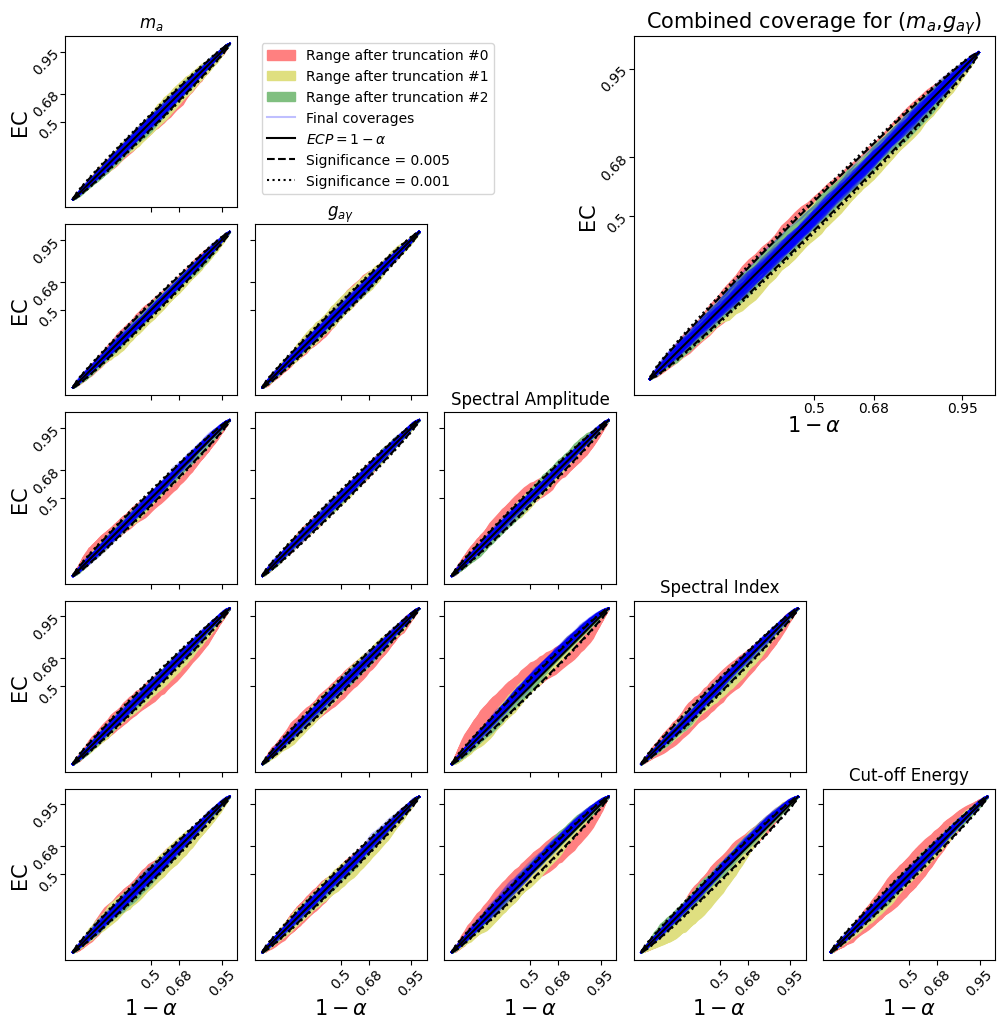

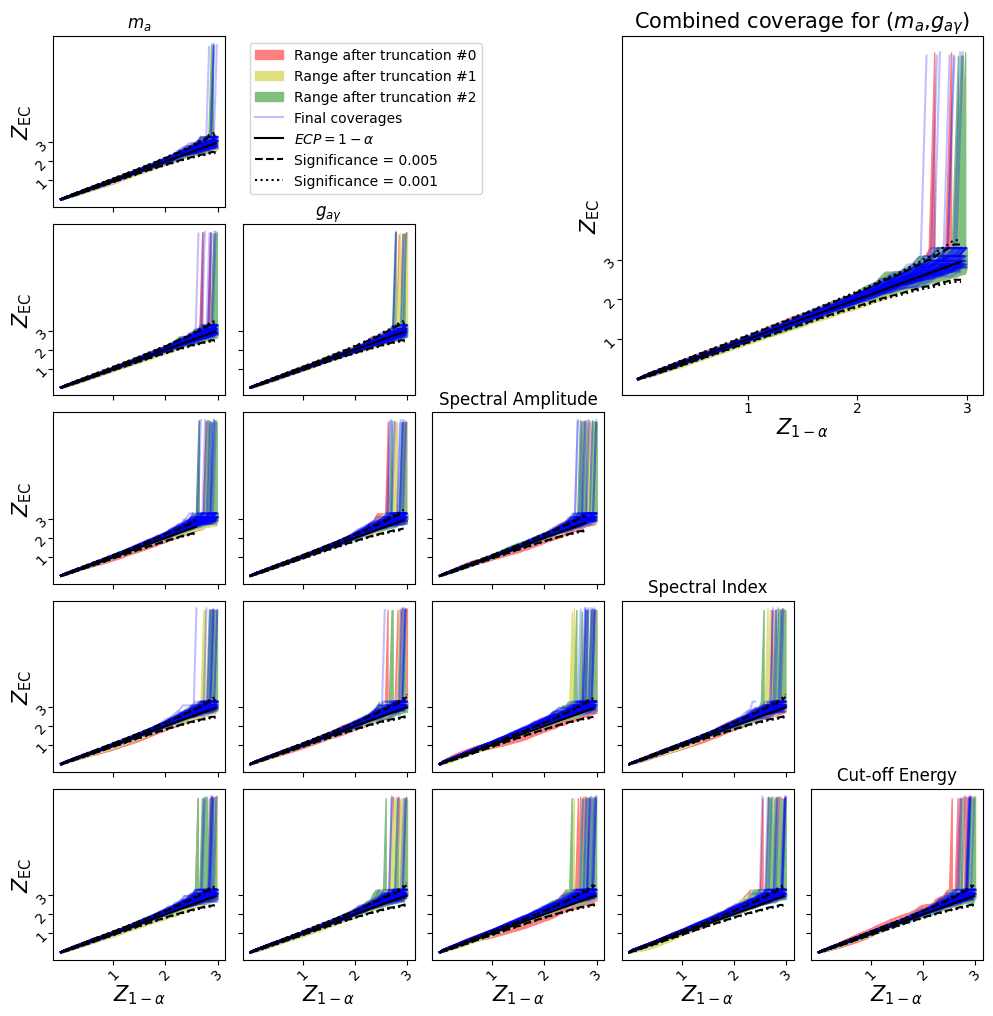

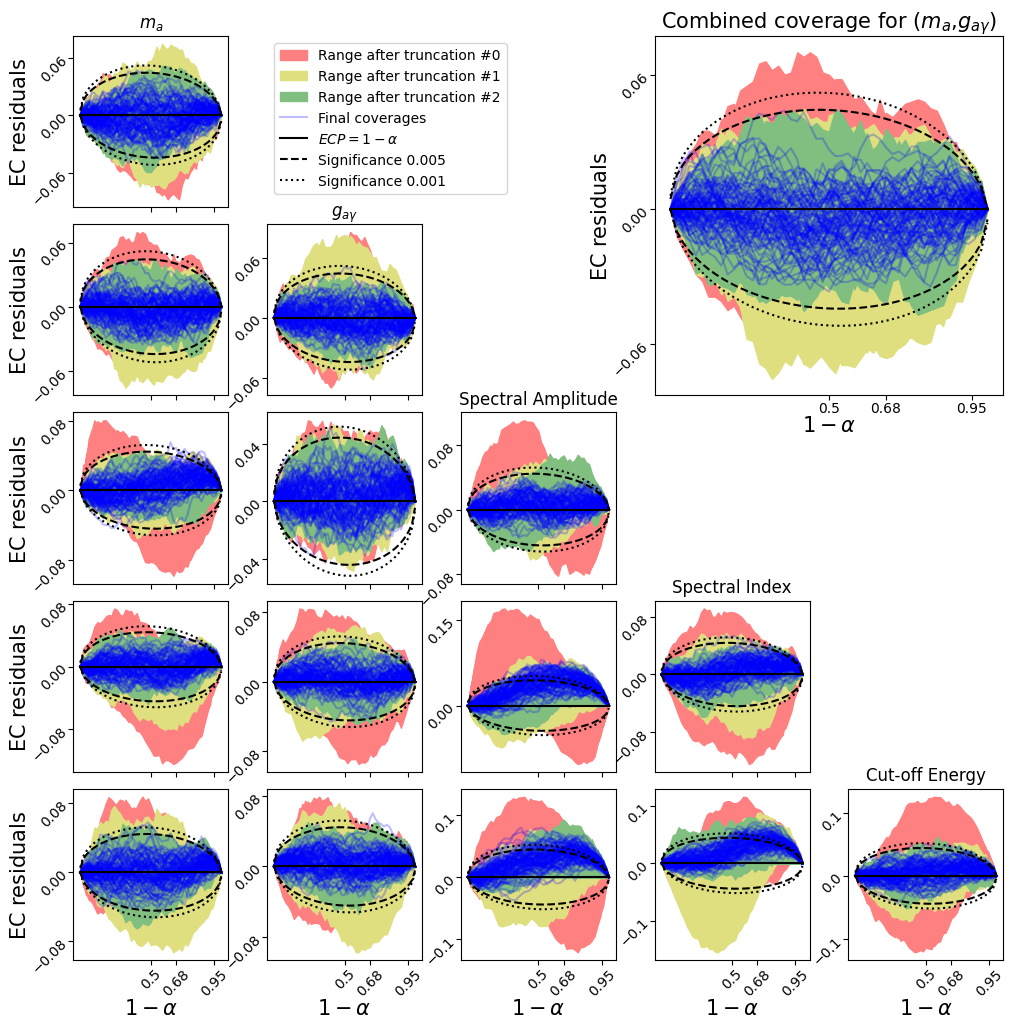

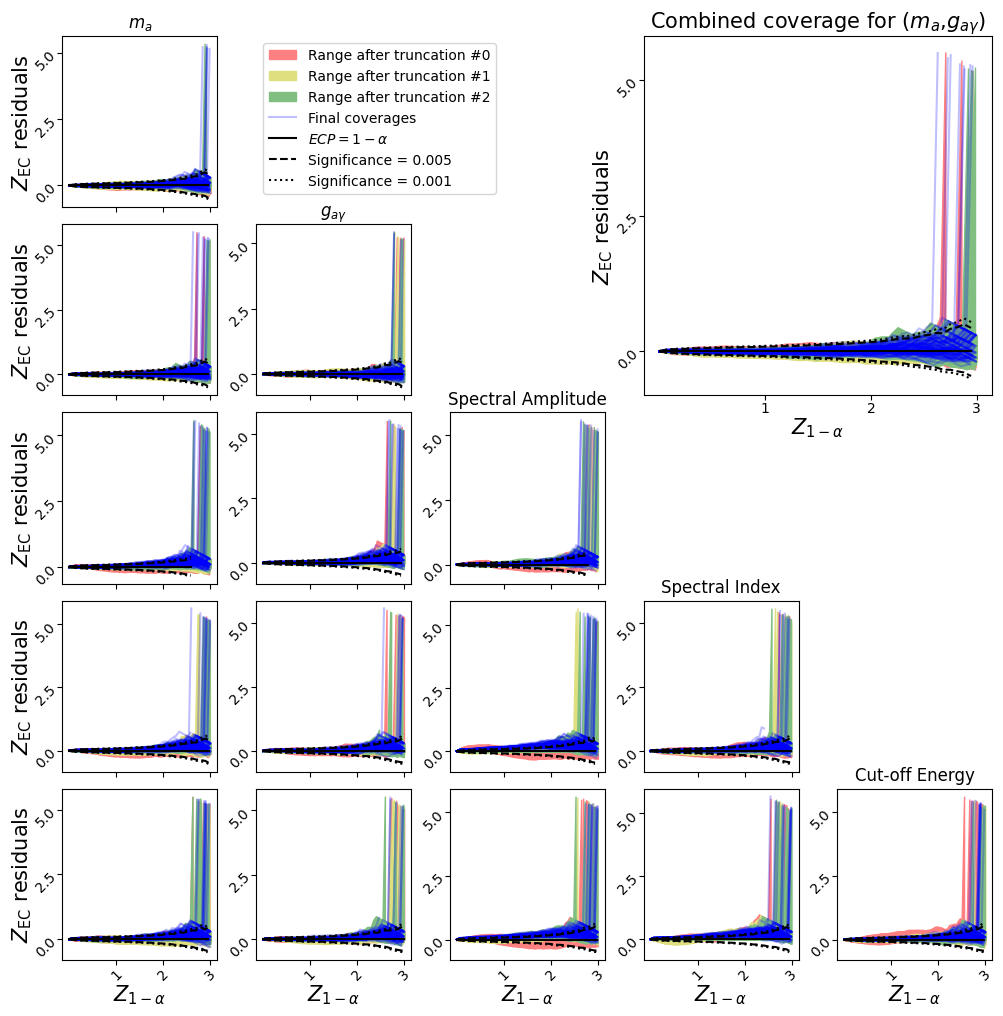

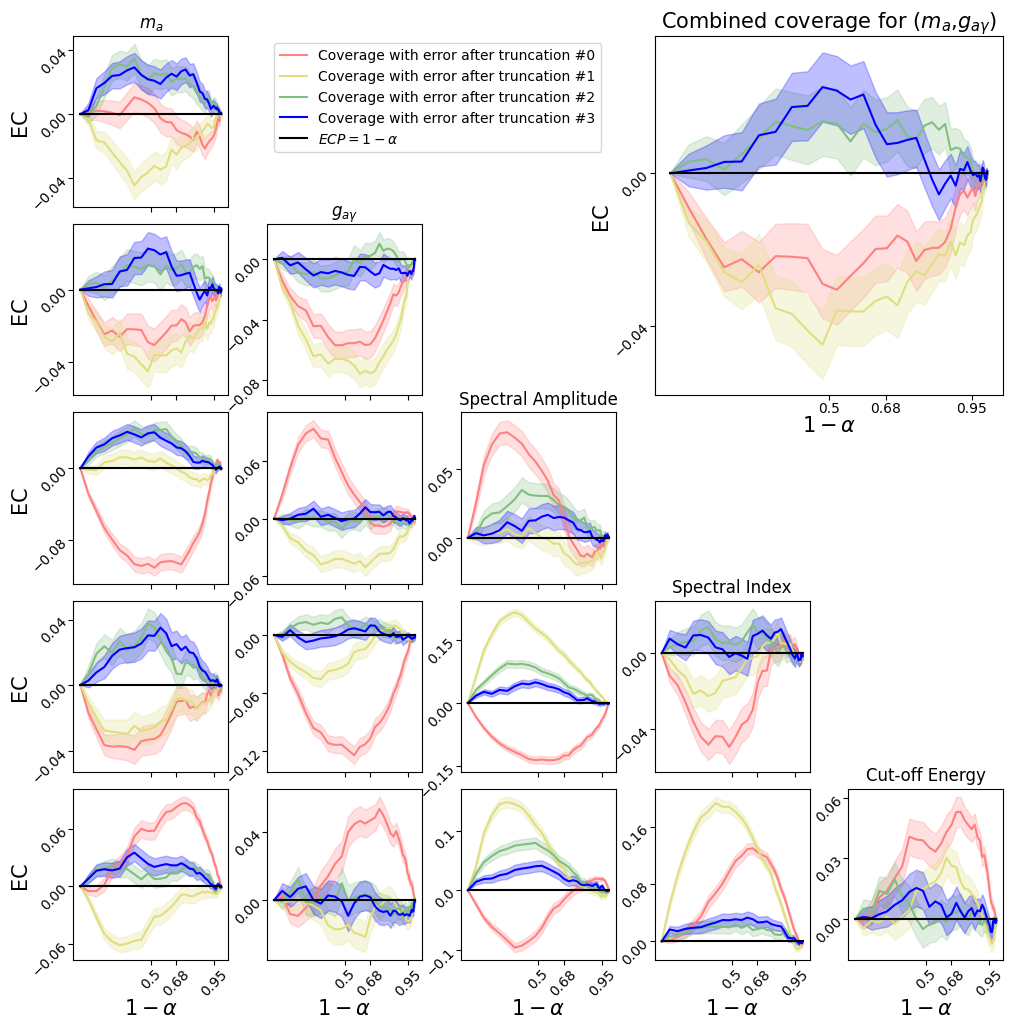

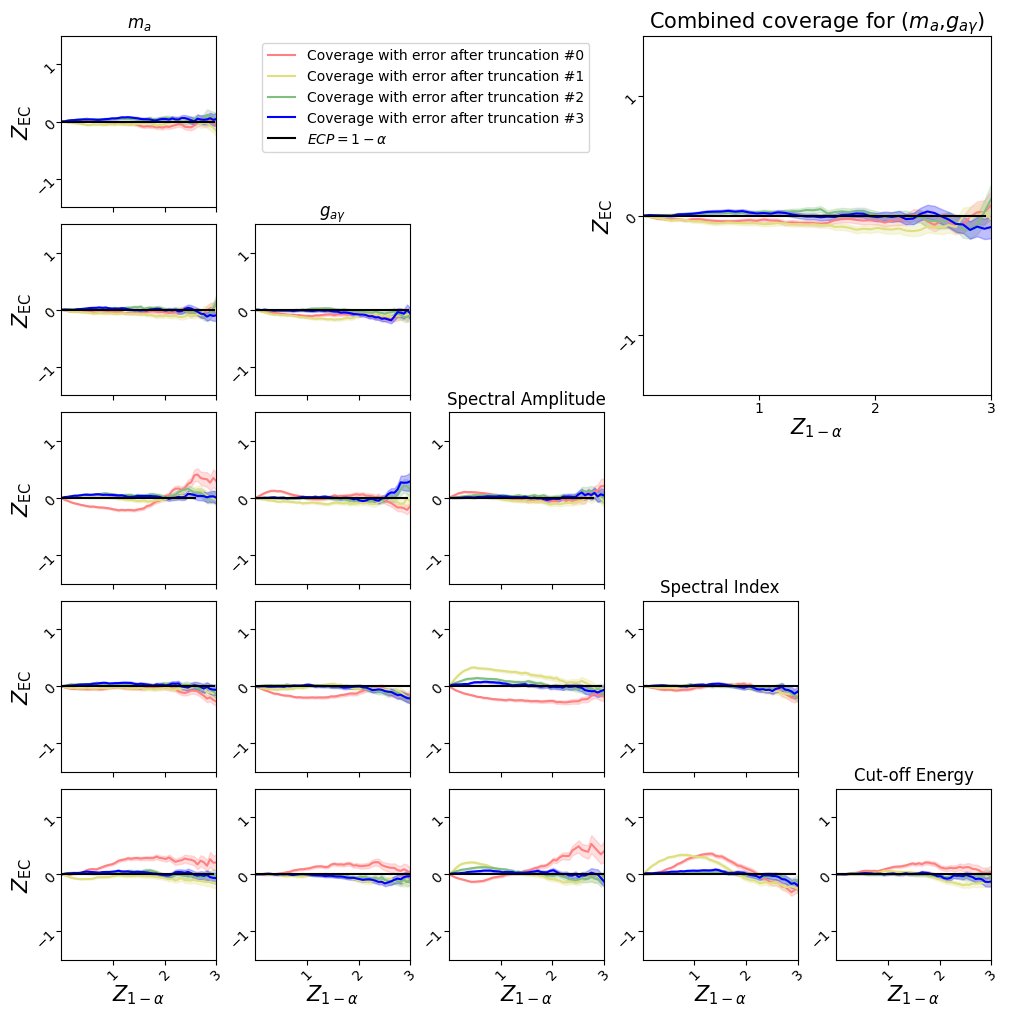

In [28]:
%%time

# CONFIGURATION
label_size = 15
label_pad = 0
tick_size = 10
x_tick_pad = 1
y_tick_pad = -1
x_tick_rotation = 45
y_tick_rotation = 45
max_z =3
significance1 = 5/n_samps
significance2 = 1/n_samps
blend_amount = 0.5
opacity = 0.25
HPD_residuals = True
legend_loc = (0,2.1)

automatic_rel_ticks = True

x_axis_pp = "$1-\\alpha$"
y_axis_pp = 'EC' #"$\mathrm{ECP}$"
ticks_pp = [0.5,0.68,0.95]

x_axis_zz = "$Z_{1-\\alpha}$"
y_axis_zz = "$Z_\mathrm{EC}$"
ticks_zz = [1,2,3]

x_axis_rel = "$1-\\alpha$"
y_axis_rel = "$\mathrm{EC}$ residuals"
x_ticks_rel = ticks_pp
y_ticks_rel = [-0.1,1,0.1]

x_axis_rel_zz = "$Z_{1-\\alpha}$"
y_axis_rel_zz = "$Z_\mathrm{EC}$ residuals"
x_ticks_rel_zz = ticks_zz
y_ticks_rel_zz = [-1,0,1]

POI_names = ['$m_a$', '$g_{a \\gamma}$', 'Spectral Amplitude', 'Spectral Index', 'Cut-off Energy']

x_axis_list = [x_axis_pp,x_axis_zz,x_axis_rel,x_axis_rel_zz,x_axis_pp,x_axis_zz]
y_axis_list = [y_axis_pp,y_axis_zz,y_axis_rel,y_axis_rel_zz,y_axis_pp,y_axis_zz]
x_tick_list = [ticks_pp,ticks_zz,ticks_pp,ticks_zz,ticks_pp,ticks_zz]

if not HPD_residuals:
    y_tick_list = [ticks_pp,ticks_zz,y_ticks_rel,y_ticks_rel_zz,y_ticks_rel,y_ticks_rel_zz]
else:
    y_tick_list = [ticks_pp,ticks_zz,y_ticks_rel,y_ticks_rel_zz,x_ticks_rel,x_ticks_rel_zz]

adjusted_colors = [blend(to_rgb(col),(1,1,1),amount=blend_amount) for col in round_colors[:-1]]
adjusted_colors.append(round_colors[-1])

rows = len(POIs)


DRP_fig_pp = plt.figure(figsize = (12, 12))
DRP_fig_zz = plt.figure(figsize = (12, 12))
DRP_fig_rel = plt.figure(figsize = (12, 12))
DRP_fig_rel_zz = plt.figure(figsize = (12, 12))
DRP_fig_HPD_pp = plt.figure(figsize = (12, 12))
DRP_fig_HPD_zz = plt.figure(figsize = (12, 12))

fig_list = [DRP_fig_pp,DRP_fig_zz,DRP_fig_rel,DRP_fig_rel_zz, DRP_fig_HPD_pp,DRP_fig_HPD_zz]


DRP_fig_pp.subplots_adjust(hspace=0.1, wspace=0.1)
DRP_fig_zz.subplots_adjust(hspace=0.1, wspace=0.1)
DRP_fig_rel.subplots_adjust(hspace=0.1, wspace=0.27)
DRP_fig_rel_zz.subplots_adjust(hspace=0.1, wspace=0.25)
if HPD_residuals:
    DRP_fig_HPD_pp.subplots_adjust(hspace=0.1, wspace=0.27)
    DRP_fig_HPD_zz.subplots_adjust(hspace=0.1, wspace=0.25)
else:
    DRP_fig_HPD_pp.subplots_adjust(hspace=0.1, wspace=0.1)
    DRP_fig_HPD_zz.subplots_adjust(hspace=0.1, wspace=0.1)


#ITERATION OVER FIGURES AND SUBFIGURES

row = -1
column = 0
index_1d=-1
index_2d=-1
keys_1d = list(draws1d['round_0'].keys())
keys_2d = list(draws2d['round_0'].keys())
make_extra_plot = False
gs = gridspec.GridSpec(5,5)
i = -1
while i < len(keys_1d)+len(keys_2d)-1:
    i+=1
    if not make_extra_plot:
        row+=1
        if row == rows:
            column+=1
            row = column
        if row == column:
            dims = 0
            index_1d += 1
            key = keys_1d[index_1d]
        else:
            dims = 1
            index_2d += 1
            key = keys_2d[index_2d]

        for fig_i, fig in enumerate(fig_list): fig.add_subplot(rows, rows, rows*row+column+1)
            
    else:
        for fig_i, fig in enumerate(fig_list): fig.add_subplot(gs[:-3,3:])

    print(str(i)+'/'+str(len(keys_1d)+len(keys_2d))+' ('+str(row)+','+str(column)+')',flush=True,end='\r')

    # PLOTTING OF COVERAGES
    
    for rnd in range(which_truncation+1):
        round = 'round_'+str(rnd)
        for ref_i in range(len(references_2d)):
            ecp_ex_pp = np.zeros(len(ecp_pp[round][dims][ref_i][key])+1)
            alpha_ex_pp = np.zeros(len(alpha_pp[round][dims][ref_i][key])+1)
            ecp_ex_zz = np.zeros(len(ecp_zz[round][dims][ref_i][key])+1)
            alpha_ex_zz_orig = np.zeros(len(alpha_zz[round][dims][ref_i][key])+1)
            ecp_ex_pp[1:] = ecp_pp[round][dims][ref_i][key]
            alpha_ex_pp[1:] = alpha_pp[round][dims][ref_i][key]
            ecp_ex_zz[1:] = ecp_zz[round][dims][ref_i][key]
            alpha_ex_zz_orig[1:] = alpha_zz[round][dims][ref_i][key]
            alpha_ex_zz = alpha_ex_zz_orig[alpha_ex_zz_orig<=max_z]
            ecp_ex_zz = ecp_ex_zz[alpha_ex_zz_orig<=max_z]
            if rnd < which_truncation:
                label = 'Range after truncation #' + str(rnd) if ref_i == 0 else None
                DRP_fig_pp.axes[-1].fill_between(alpha_ex_pp,ecp_ex_pp,alpha_ex_pp, color=adjusted_colors[rnd],label=label)
                DRP_fig_zz.axes[-1].fill_between(alpha_ex_zz,ecp_ex_zz,alpha_ex_zz, color=adjusted_colors[rnd],label=label)
                DRP_fig_rel.axes[-1].fill_between(alpha_ex_pp,(ecp_ex_pp-alpha_ex_pp),np.zeros(len(alpha_ex_pp)), color=adjusted_colors[rnd],label=label)
                DRP_fig_rel_zz.axes[-1].fill_between(alpha_ex_zz,(ecp_ex_zz-alpha_ex_zz),np.zeros(len(alpha_ex_zz)), color=adjusted_colors[rnd],label=label)  
            else:
                label = 'Final coverages' if ref_i == 0 else None
                DRP_fig_pp.axes[-1].plot(alpha_ex_pp, ecp_ex_pp, round_colors[rnd],alpha=opacity,label=label)
                DRP_fig_zz.axes[-1].plot(alpha_ex_zz, ecp_ex_zz, round_colors[rnd],alpha=opacity,label=label)
                DRP_fig_rel.axes[-1].plot(alpha_ex_pp, (ecp_ex_pp-alpha_ex_pp), round_colors[rnd],alpha=opacity,label=label)
                DRP_fig_rel_zz.axes[-1].plot(alpha_ex_zz, (ecp_ex_zz-alpha_ex_zz), round_colors[rnd],alpha=opacity,label=label)
        label = 'Coverage with error after truncation #' + str(rnd)
        if dims == 0:
            swyft.plot_pp(coverage_samples[round], key,ax = DRP_fig_HPD_pp.axes[-1],color=adjusted_colors[rnd],interval_opacity=0.25,label=label,interval_label=None,x_label=None,y_label=None,diagonal_color=None,residuals=True)
            swyft.plot_zz(coverage_samples[round], key,ax = DRP_fig_HPD_zz.axes[-1],color=adjusted_colors[rnd],interval_opacity=0.25,sigma_color=None,label=label,interval_label=None,x_label=None,y_label=None,diagonal_color=None,residuals=True,z_max=max_z)
        else:
            swyft.plot_pp(coverage_samples[round], eval(key.replace(' ',',')),ax = DRP_fig_HPD_pp.axes[-1],color=adjusted_colors[rnd],interval_opacity=0.25,label=label,interval_label=None,x_label=None,y_label=None,diagonal_color=None,residuals=HPD_residuals)
            swyft.plot_zz(coverage_samples[round], eval(key.replace(' ',',')),ax = DRP_fig_HPD_zz.axes[-1],color=adjusted_colors[rnd],interval_opacity=0.25,sigma_color=None,label=label,interval_label=None,x_label=None,y_label=None,diagonal_color=None,residuals=HPD_residuals,z_max=max_z)
    
    
    #CONFIGURATION OF INDIVIDUAL AXES
    
    for fig_i, fig in enumerate(fig_list): 
        fig.axes[-1].set_xticks(x_tick_list[fig_i])
        fig.axes[-1].set_xticklabels([])
        fig.axes[-1].set_yticks(y_tick_list[fig_i])
        fig.axes[-1].set_yticklabels([])

    if automatic_rel_ticks:
        DRP_fig_rel.axes[-1].yaxis.set_major_locator(MaxNLocator(nbins=3))
        DRP_fig_rel_zz.axes[-1].yaxis.set_major_locator(MaxNLocator(nbins=3))
        DRP_fig_HPD_pp.axes[-1].yaxis.set_major_locator(MaxNLocator(nbins=3))
        DRP_fig_HPD_zz.axes[-1].yaxis.set_major_locator(MaxNLocator(nbins=3))

        DRP_fig_rel.axes[-1].yaxis.set_major_formatter(plt.ScalarFormatter(None))
        DRP_fig_rel_zz.axes[-1].yaxis.set_major_formatter(plt.ScalarFormatter(None))
        DRP_fig_HPD_pp.axes[-1].yaxis.set_major_formatter(plt.ScalarFormatter(None))
        DRP_fig_HPD_zz.axes[-1].yaxis.set_major_formatter(plt.ScalarFormatter(None))

        DRP_fig_pp.axes[-1].set_yticks(ticks_pp)
        DRP_fig_zz.axes[-1].set_yticks(ticks_zz)
        
    if row==column:
        for fig_i, fig in enumerate(fig_list): fig.axes[-1].set_title(POI_names[row])
  
    if row==rows-1:
        for fig_i, fig in enumerate(fig_list): 
            fig.axes[-1].tick_params(axis='x',labelsize=tick_size,pad=x_tick_pad,rotation=x_tick_rotation)
            # fig.axes[-1].set_xticks(x_tick_list[fig_i])
            fig.axes[-1].set_xticklabels(x_tick_list[fig_i])
            fig.axes[-1].set_xlabel(x_axis_list[fig_i], fontsize=label_size, labelpad=label_pad)
        
    if column == 0:
        DRP_fig_pp.axes[-1].set_yticklabels(ticks_pp)
        DRP_fig_zz.axes[-1].set_yticklabels(ticks_zz)
        for fig_i, fig in enumerate(fig_list): 
            fig.axes[-1].set_ylabel(y_axis_list[fig_i], fontsize=label_size, labelpad=label_pad)
            if not automatic_rel_ticks: fig.axes[-1].set_yticklabels(y_tick_list[fig_i])
            
    for fig_i, fig in enumerate(fig_list):
        fig.axes[-1].tick_params(axis='y',labelsize=tick_size,rotation=y_tick_rotation, pad=y_tick_pad)

    uncertainty1 = interval((alpha_ex_pp*n_samps).astype(int),n_samps,alpha = significance1)
    upper_uncertainty1 = uncertainty1[:,0]
    lower_uncertainty1 = uncertainty1[:,1]
    uncertainty2 = interval((alpha_ex_pp*n_samps).astype(int),n_samps,alpha = significance2)
    upper_uncertainty2 = uncertainty2[:,0]
    lower_uncertainty2 = uncertainty2[:,1]
    uncertainty1_zz = interval((z_to_p(alpha_ex_zz)*n_samps).astype(int),n_samps,alpha=significance1)
    upper_uncertainty1_zz = p_to_z(uncertainty1_zz[:,1])
    lower_uncertainty1_zz = p_to_z(uncertainty1_zz[:,0])
    uncertainty2_zz = interval((z_to_p(alpha_ex_zz)*n_samps).astype(int),n_samps,alpha=significance2)
    upper_uncertainty2_zz = p_to_z(uncertainty2_zz[:,1])
    lower_uncertainty2_zz = p_to_z(uncertainty2_zz[:,0])

    DRP_fig_pp.axes[-1].plot(alpha_ex_pp, alpha_ex_pp,'k-',label='$ECP=1-\\alpha$')
    DRP_fig_pp.axes[-1].plot(alpha_ex_pp, upper_uncertainty1,'k--', label='Significance = {:1g}'.format(significance1))
    DRP_fig_pp.axes[-1].plot(alpha_ex_pp, lower_uncertainty1,'k--')
    DRP_fig_pp.axes[-1].plot(alpha_ex_pp, upper_uncertainty2,'k:', label='Significance = {:1g}'.format(significance2))
    DRP_fig_pp.axes[-1].plot(alpha_ex_pp, lower_uncertainty2,'k:')

    DRP_fig_rel.axes[-1].plot(alpha_ex_pp, (alpha_ex_pp-alpha_ex_pp), 'k-',label='$ECP=1-\\alpha$')
    DRP_fig_rel.axes[-1].plot(alpha_ex_pp, (upper_uncertainty1-alpha_ex_pp), 'k--',label='Significance '+str(significance1))
    DRP_fig_rel.axes[-1].plot(alpha_ex_pp, (lower_uncertainty1-alpha_ex_pp), 'k--')
    DRP_fig_rel.axes[-1].plot(alpha_ex_pp, (upper_uncertainty2-alpha_ex_pp), 'k:',label='Significance '+str(significance2))
    DRP_fig_rel.axes[-1].plot(alpha_ex_pp, (lower_uncertainty2-alpha_ex_pp), 'k:')

    DRP_fig_zz.axes[-1].plot(alpha_ex_zz, alpha_ex_zz, 'k-',label='$ECP=1-\\alpha$')
    DRP_fig_zz.axes[-1].plot(alpha_ex_zz, upper_uncertainty1_zz,'k--',label='Significance = {:1g}'.format(significance1))
    DRP_fig_zz.axes[-1].plot(alpha_ex_zz, lower_uncertainty1_zz,'k--')
    DRP_fig_zz.axes[-1].plot(alpha_ex_zz, upper_uncertainty2_zz,'k:',label='Significance = {:1g}'.format(significance2))
    DRP_fig_zz.axes[-1].plot(alpha_ex_zz, lower_uncertainty2_zz,'k:')
    # DRP_fig_zz.axes[-1].set_ylim([0,max_z+1])
    
    DRP_fig_rel_zz.axes[-1].plot(alpha_ex_zz, (alpha_ex_zz-alpha_ex_zz), 'k-',label='$ECP=1-\\alpha$')
    DRP_fig_rel_zz.axes[-1].plot(alpha_ex_zz, (upper_uncertainty1_zz-alpha_ex_zz), 'k--',label='Significance = {:1g}'.format(significance1))
    DRP_fig_rel_zz.axes[-1].plot(alpha_ex_zz, (lower_uncertainty1_zz-alpha_ex_zz), 'k--')
    DRP_fig_rel_zz.axes[-1].plot(alpha_ex_zz, (upper_uncertainty2_zz-alpha_ex_zz), 'k:',label='Significance = {:1g}'.format(significance2))
    DRP_fig_rel_zz.axes[-1].plot(alpha_ex_zz, (lower_uncertainty2_zz-alpha_ex_zz), 'k:')
    # DRP_fig_rel_zz.axes[-1].set_ylim([-0.5*max_z,0.5*max_z])
  
    if HPD_residuals:
        DRP_fig_HPD_pp.axes[-1].plot(alpha_ex_pp, (alpha_ex_pp-alpha_ex_pp), 'k-',label='$ECP=1-\\alpha$')
        DRP_fig_HPD_zz.axes[-1].plot(alpha_ex_zz, (alpha_ex_zz-alpha_ex_zz), 'k-',label='$ECP=1-\\alpha$')
        DRP_fig_HPD_zz.axes[-1].set_ylim([-0.5*max_z,0.5*max_z])
    else:
        DRP_fig_HPD_pp.axes[-1].plot(alpha_ex_pp, alpha_ex_pp, 'k-',label='$ECP=1-\\alpha$')
        DRP_fig_HPD_zz.axes[-1].plot(alpha_ex_zz, alpha_ex_zz, 'k-',label='$ECP=1-\\alpha$')
        DRP_fig_HPD_zz.axes[-1].set_ylim([0,max_z])


    # DEALING WITH EXTRA AXIS OUTSIDE CORNER PLOT
    
    if row==1 and column==0:
        if not make_extra_plot:
            i -= 1
            make_extra_plot=True
        else:
            make_extra_plot=False

            extra_title = 'Combined coverage for ('+POI_names[0]+','+POI_names[1]+')'
            extra_title_size = 15
            extra_legend_size = 10
            extra_legend_loc = legend_loc

            for fig_i, fig in enumerate(fig_list):
                fig.axes[-1].set_xticks(x_tick_list[fig_i])
                fig.axes[-1].set_xticklabels(x_tick_list[fig_i])
                fig.axes[-1].tick_params(axis='x',labelsize=tick_size,pad=x_tick_pad)
                fig.axes[-1].tick_params(axis='y',labelsize=tick_size,pad=y_tick_pad)
                fig.axes[-1].set_xlabel(x_axis_list[fig_i], fontsize=label_size, labelpad=label_pad)
                fig.axes[-1].set_ylabel(y_axis_list[fig_i], fontsize=label_size, labelpad=label_pad)
                fig.axes[-1].set_title(extra_title, fontsize=extra_title_size)
                
           
            # DRP_fig_pp.axes[-1].set_yticks(ticks_pp)
            DRP_fig_pp.axes[-1].set_yticklabels(ticks_pp)
            # DRP_fig_zz.axes[-1].set_yticks(ticks_zz)
            DRP_fig_zz.axes[-1].set_yticklabels(ticks_zz)
            if not HPD_residuals:
                DRP_fig_HPD_pp.axes[-1].set_yticklabels(ticks_pp)
                DRP_fig_HPD_zz.axes[-1].set_yticklabels(ticks_zz)
    
    elif row==1 and column==1:
        extra_title_size = 15
        extra_legend_size = 10
        for fig_i, fig in enumerate(fig_list):
            fig.axes[-1].legend(prop={'size': extra_legend_size}, loc = "upper left", bbox_to_anchor=extra_legend_loc)
  

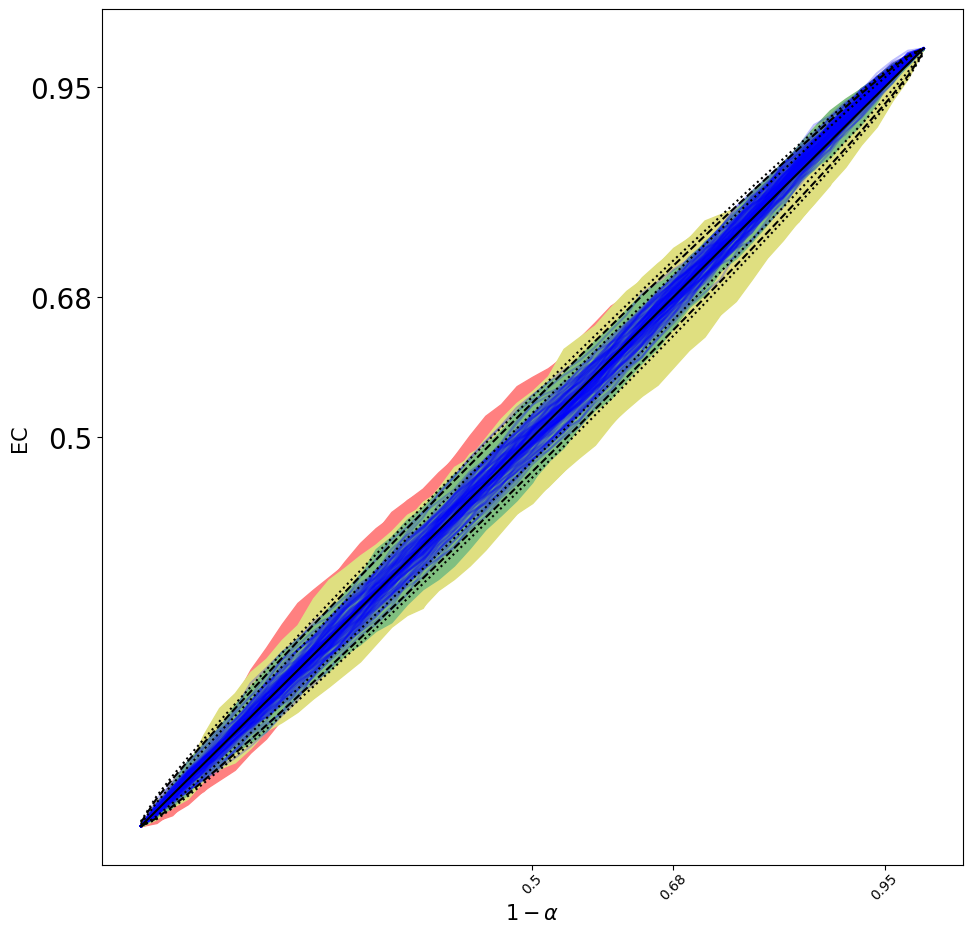

In [21]:
for ax in DRP_fig_pp.axes:
    ax.set_visible(False)
DRP_fig_pp.axes[5].set_visible(True)
DRP_fig_pp.axes[5].plot(alpha_ex_pp,interval((alpha_ex_pp*n_samps).astype(int),n_samps)[:,0], 'k:')
DRP_fig_pp.axes[5].plot(alpha_ex_pp,interval((alpha_ex_pp*n_samps).astype(int),n_samps)[:,1], 'k:')
DRP_fig_pp.set_figheight(12*5)
DRP_fig_pp.set_figwidth(12*5)
DRP_fig_pp

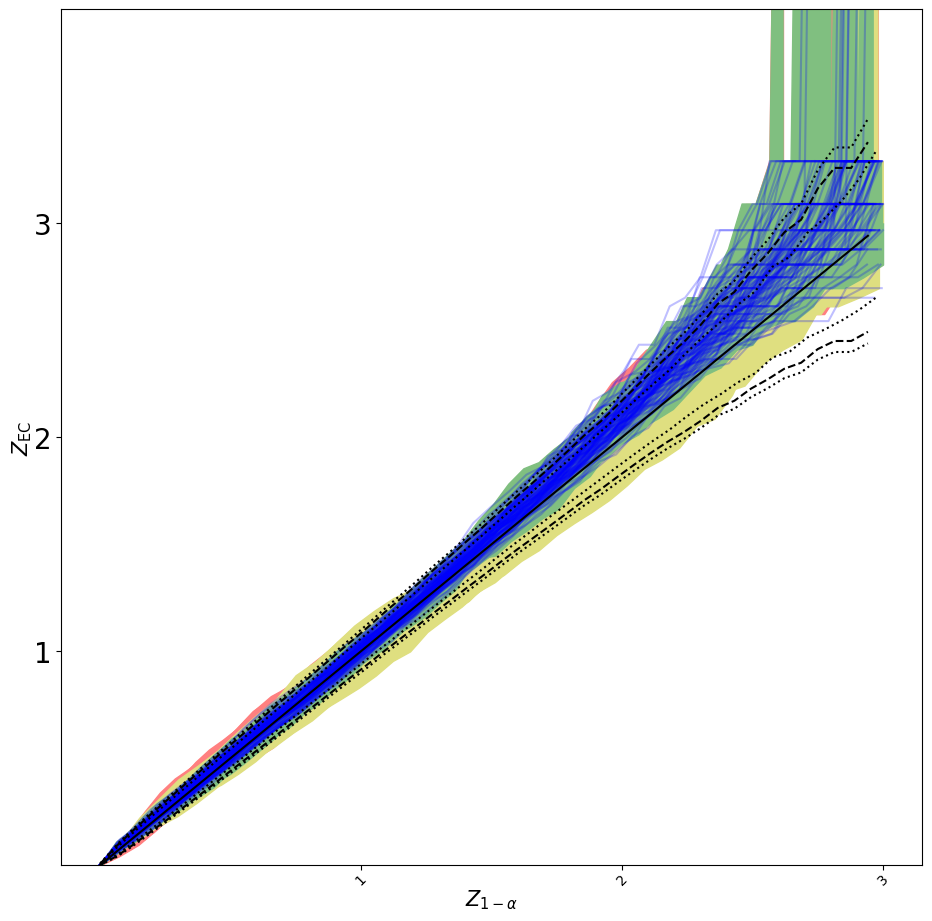

In [22]:
for ax in DRP_fig_zz.axes:
    ax.set_visible(False)
DRP_fig_zz.axes[5].set_visible(True)
DRP_fig_zz.axes[5].plot(alpha_ex_zz,p_to_z(interval((z_to_p(alpha_ex_zz)*n_samps).astype(int),n_samps)[:,0]), 'k:')
DRP_fig_zz.axes[5].plot(alpha_ex_zz,p_to_z(interval((z_to_p(alpha_ex_zz)*n_samps).astype(int),n_samps)[:,1]), 'k:')
DRP_fig_zz.set_figheight(12*5)
DRP_fig_zz.set_figwidth(12*5)
DRP_fig_zz

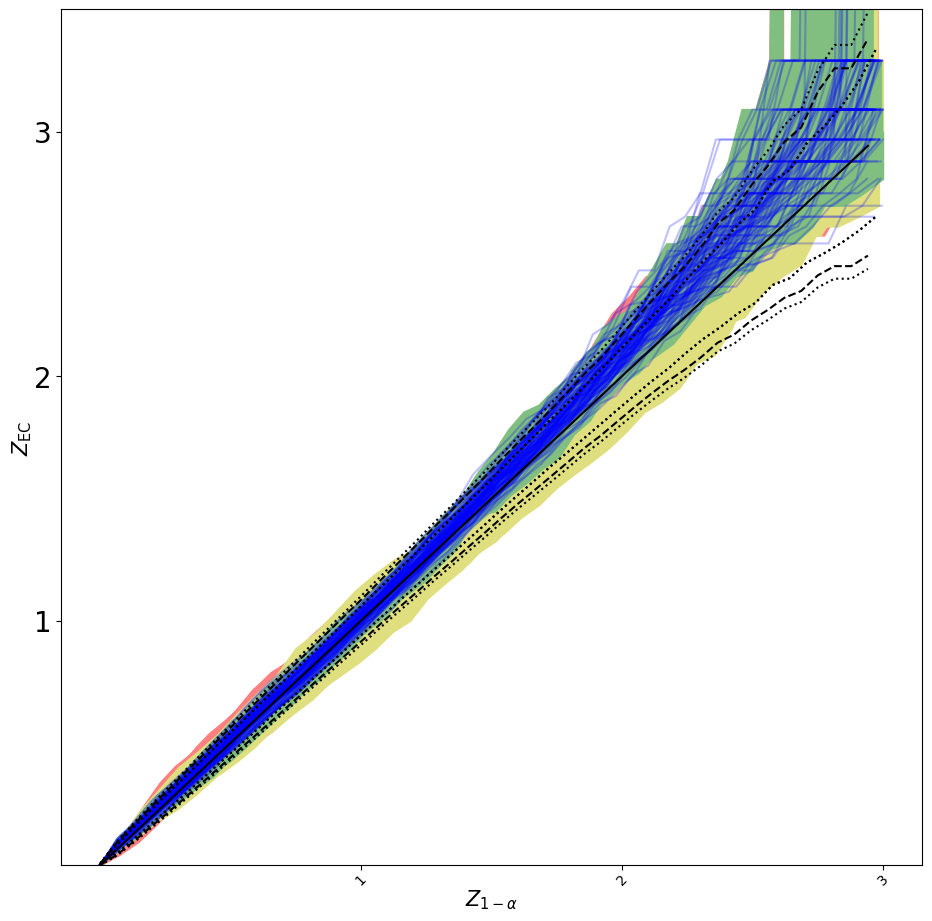

In [23]:
for ax in DRP_fig_zz.axes:
    ax.set_visible(False)
DRP_fig_zz.axes[5].set_visible(True)
DRP_fig_zz.axes[5].plot(alpha_ex_zz,p_to_z(interval((z_to_p(alpha_ex_zz)*n_samps).astype(int),n_samps)[:,0]), 'k:')
DRP_fig_zz.axes[5].plot(alpha_ex_zz,p_to_z(interval((z_to_p(alpha_ex_zz)*n_samps).astype(int),n_samps)[:,1]), 'k:')
DRP_fig_zz.axes[5].set_ylim(0,3.5)
DRP_fig_zz.set_figheight(12*5)
DRP_fig_zz.set_figwidth(12*5)
DRP_fig_zz

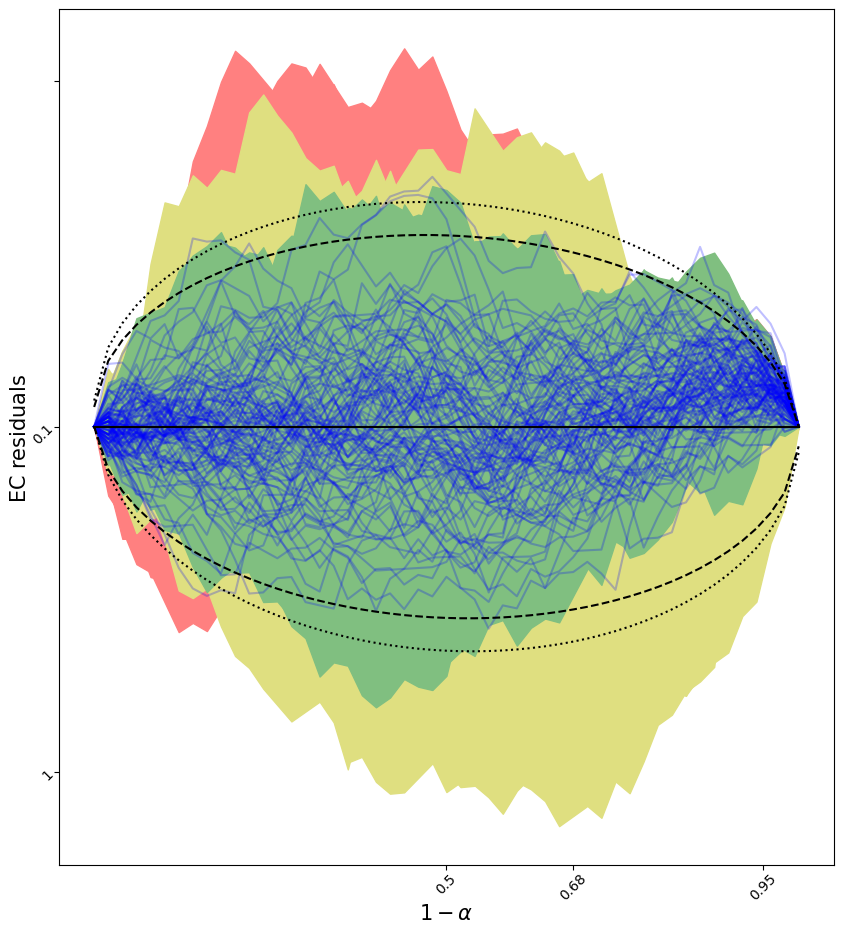

In [24]:
for ax in DRP_fig_rel.axes:
    ax.set_visible(False)
DRP_fig_rel.axes[5].set_visible(True)
DRP_fig_rel.set_figheight(12*5)
DRP_fig_rel.set_figwidth(12*5)
DRP_fig_rel

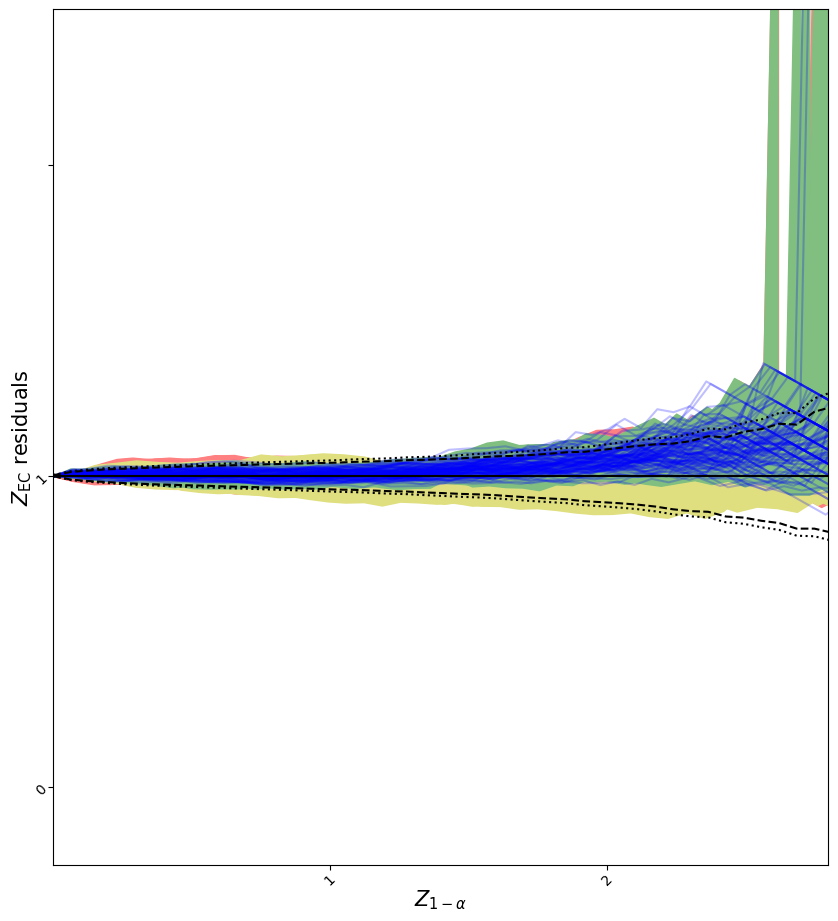

In [25]:
for ax in DRP_fig_rel_zz.axes:
    ax.set_visible(False)
DRP_fig_rel_zz.axes[5].set_visible(True)
DRP_fig_rel_zz.axes[5].set_xlim([0,2.8])
DRP_fig_rel_zz.axes[5].set_ylim([-2.5,3])
DRP_fig_rel_zz.set_figheight(12*5)
DRP_fig_rel_zz.set_figwidth(12*5)
DRP_fig_rel_zz